In [81]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../../../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

plt.style.use(["science","bright","grid"])

In [82]:
def run_simulation(time_steps, voltages, topology_parameter, radius=1e5, eq_steps=0):

    np_info2 = {
        'np_index'      : [int(topology_parameter["Nx"]**2-(topology_parameter["Nx"]+1)//2)], 
        'mean_radius'   : radius,
        'std_radius'    : 0.0
    }

    target_electrode    = len(topology_parameter["e_pos"])-1
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, np_info2=np_info2)
    sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode,
                               stat_size=10, save=False, eq_steps=eq_steps)
    results             = sim_class.return_output_values()

    return results

In [83]:
results     = []
N_min       = 3
N_max       = 16
N_vals      = np.arange(N_min, N_max+1, 1)
N_voltages  = 201
radius      = 1e7
U_input     = np.linspace(0, 0.2, N_voltages, endpoint=True)

for N_p in N_vals:

    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],[0,(N_p-1)//2,0],
                               [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant','constant','constant',
                               'constant','constant','constant','floating']
    }

    # Voltage Paramter
    time_step       = 1e-8
    time_steps      = np.arange(N_voltages)*time_step
    voltages        = np.zeros(shape=(N_voltages,(len(topology_parameter['e_pos'])+1)))
    voltages[:,0]   = U_input
    
    val = run_simulation(time_steps, voltages, topology_parameter, radius, 0)
    results.append(val)

In [84]:
x_vals  = U_input[1:]*1000
df      = 1000*pd.DataFrame(np.array([arr[:,2] for arr in results]).T, columns=N_vals**2)
df_e    = 1000*pd.DataFrame(np.array([arr[:,3] for arr in results]).T, columns=N_vals**2)

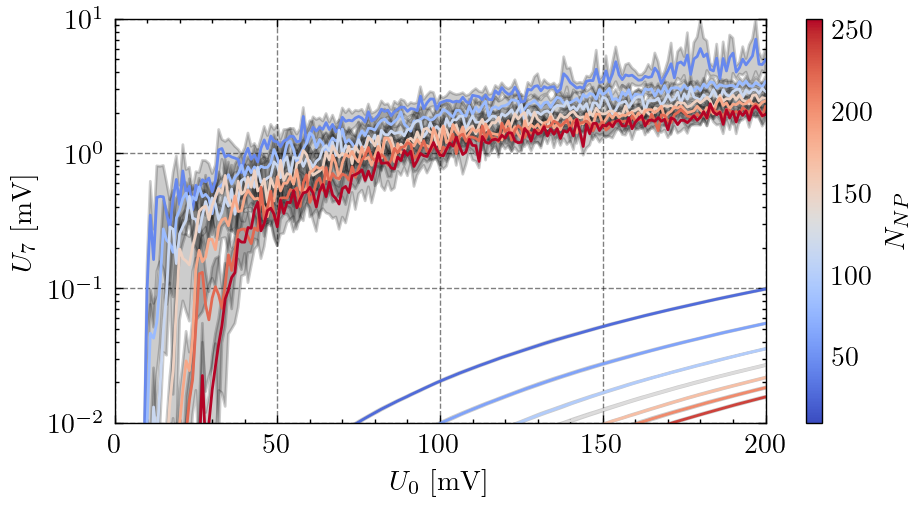

In [87]:
cmap    = plt.get_cmap("coolwarm")
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)

for i, col in enumerate(df.columns):

    ax.plot(x_vals, df[col].values, c=cmap((i+1)/len(N_vals)))
    ax.fill_between(x_vals, df[col].values-df_e[col].values, df[col].values+df_e[col].values,
                    color='black', alpha=0.2)

ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$U_7$ [mV]")
ax.set_xlim(0,200)
ax.set_yscale('log')
ax.set_ylim(1e-2,1e1)

norm    = mpl.colors.Normalize(vmin=N_min**2, vmax=N_max**2)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cbar, ax=ax, label='$N_{NP}$', aspect=25)